In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import torch
import os
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from typing import Any, List, Dict, Tuple

from pathlib import Path

from metricstracker import MetricsTracker

/opt/rocm/lib/libamd_smi.so: cannot open shared object file: No such file or directory
Unable to find amdsmi library try installing amd-smi-lib from your package manager


2025-03-06 16:36:50.789927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 16:36:50.789982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 16:36:50.790012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 16:36:50.796229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 16:36:51.556924: W tensorflow/compiler/

In [2]:
BASE_DIR = Path.cwd().parents[1]
MODELLING_DIR = BASE_DIR / 'src' / 'modelling'
print(BASE_DIR)

torch.manual_seed(32)

os.chdir(BASE_DIR)
from modelling.train import init_model, init_main_optimizer, init_main_scheduler, init_early_stopper, print_epoch_loss
from modelling.GRU import GRU
from modelling.EarlyStopper import EarlyStopper
from modelling.grid_search import update_dict
from run_forecast import load_data


N_HOURS_U = 72                    # number of hours to use for input
N_HOURS_Y = 24                    # number of hours to predict
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars


/home/nick/bachelor-project/forecasting_smog_DL_GNN/src

Running __init__.py for data pipeline...
Modelling package initialized



/home/nick/bachelor-project/forecasting_smog_DL_GNN/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tracker = MetricsTracker(
    experiment_name='GRU',
    log_dir=BASE_DIR / 'results' / 'energy_logs',
    track_energy=True,
    track_tensorboard=True,
    track_memory=True,
    verbose=True,
)

cuda
[2025-03-06 16:36:52,339] [zeus.device.gpu.nvidia](nvidia.py:47) pynvml is available and initialized.
[2025-03-06 16:36:52,346] [zeus.device.cpu.rapl](rapl.py:137) RAPL is not supported on this CPU.
[2025-03-06 16:36:52,347] [zeus.monitor.energy](energy.py:209) Monitoring GPU indices [0].
[2025-03-06 16:36:52,348] [zeus.monitor.energy](energy.py:210) Monitoring CPU indices []
[2025-03-06 16:36:52,349] [zeus.monitor.energy](energy.py:219) Writing measurement logs to /home/nick/bachelor-project/forecasting_smog_DL_GNN/src/results/energy_logs/GRU_20250306_163652/energy_20250306_163652.csv.


In [4]:
def train(
    hp: Dict[str, Any],
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    verbose: bool = True,
    device: str = "cuda"
) -> Tuple[Any, List[float], List[float], float]:
    """Train model with metrics tracking."""
    model = init_model(hp).to(device)
    optimizer = init_main_optimizer(model, hp)
    lr_scheduler = init_main_scheduler(optimizer, hp)
    early_stopper = init_early_stopper(hp, verbose)
    loss_fn = hp["loss_fn"]
    
   
    @tracker.track_window("epoch")
    def train_epoch(epoch: int):
        train_loss = 0.0
        val_loss = 0.0
        steps_data = []
        
        model.train()
        for batch_idx, (batch_u, batch_y) in enumerate(train_loader):
            step_result, step_measurement = train_step(batch_u, batch_y, epoch, batch_idx)
            train_loss += step_result['loss']
            if step_measurement:
                steps_data.append(step_measurement)
        
        model.eval()
        with torch.no_grad():
            for batch_u, batch_y in val_loader:
                batch_u = batch_u.to(device)
                batch_y = batch_y.to(device)
                val_loss += loss_fn(model(batch_u), batch_y).item()
        
        return {
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader),
            'val_loss': val_loss / len(val_loader),
            'steps_data': steps_data
        }
    
    @tracker.track_window("step")
    def train_step(batch_u: torch.Tensor, batch_y: torch.Tensor, epoch: int, step: int):
        """Single training step with energy tracking."""
        batch_u = batch_u.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_u)
        loss = loss_fn(output, batch_y.squeeze(1))
        loss.backward()
        optimizer.step()
        
        return {
            'epoch': epoch,
            'step': step,
            'loss': loss.item()
        }
    
    train_losses, val_losses = [], []
    
    try:
        for epoch in range(hp["epochs"]):
            # Train one epoch
            epoch_results, epoch_energy = train_epoch(epoch)
            # Store losses
            train_losses.append(epoch_results['train_loss'])
            val_losses.append(epoch_results['val_loss'])
            
            # Update scheduler
            lr_scheduler.step(epoch_results['val_loss'])
            
            if early_stopper(val_losses[-1], epoch, model):
                if verbose:
                    print(f"\nEarly stopping at epoch {epoch}")
                break
    
    finally:
        # Save metrics and clean up
        # tracker.plot_metrics()
        # tracker.save_metrics()
        tracker.end_tracking()
    
    return early_stopper.best_model, train_losses, val_losses

In [5]:
def train_model(hp, train_dataset, val_dataset, save_path, city_name):
    """Train the model using the given hyperparameters."""
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_loader = DataLoader(train_dataset, batch_size=hp["batch_sz"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=hp["batch_sz"], shuffle=False)

    model = hp["model_class"](
        hp["n_hours_u"],
        hp["n_hours_y"],
        hp["input_units"],
        hp["hidden_layers"],
        hp["hidden_units"],
        hp["output_units"],
    ).to(device)

    model, train_losses, val_losses, total_energy = train(hp, train_loader, val_loader, verbose=True)
    df_losses = pd.DataFrame({"L_train": train_losses, "L_val": val_losses})
    df_losses.to_csv(
        f"{os.path.join(os.getcwd(), 'src/results/final_losses')}/losses_GRU_at_{city_name}_{current_time}.csv",
        sep=";",
        decimal=".",
        encoding="utf-8",
    )

    torch.save(model.state_dict(), save_path)
    return model

In [6]:
import optuna
hp_gru = {
    'n_hours_u' : N_HOURS_U,
    'n_hours_y' : N_HOURS_Y,

    'model_class' : GRU, # changed to GRU
    'input_units' : 8, #train_dataset.__n_features_in__(),
    'hidden_layers' : 4,
    'hidden_units' : 128,
    # 'branches' : 2,  # predicting only no2 and o3
    'output_units' : 2, #train_dataset.__n_features_out__(),

    'Optimizer' : torch.optim.Adam,
    'lr_shared' : 1e-3,
    'scheduler' : torch.optim.lr_scheduler.ReduceLROnPlateau,
    'scheduler_kwargs' : {'mode' : 'min',
                          'factor' : 0.1,
                          'patience' : 3,
                          'cooldown' : 8,
                          'verbose' : True},
    'w_decay' : 1e-5,
    'loss_fn' : torch.nn.MSELoss(),

    'epochs' : 5000,
    'early_stopper' : EarlyStopper,
    'patience' : 15,
    'batch_sz' : 16,
    'k_folds' : 5,
}



In [7]:
import os
print(os.getcwd())
best_params = optuna.load_study(study_name='optuna_utrecht_16-33-31',storage="sqlite:///results/optuna_search/optuna_utrecht.db").best_params
hp_gru = update_dict(hp_gru, best_params)
hp_gru

/home/nick/bachelor-project/forecasting_smog_DL_GNN/src


{'n_hours_u': 72,
 'n_hours_y': 24,
 'model_class': modelling.GRU.GRU,
 'input_units': 8,
 'hidden_layers': 6,
 'hidden_units': 128,
 'output_units': 2,
 'Optimizer': torch.optim.adam.Adam,
 'lr_shared': 0.006549397293513188,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'scheduler_kwargs': {'mode': 'min',
  'factor': 0.1,
  'patience': 3,
  'cooldown': 8,
  'verbose': True},
 'w_decay': 2.459722776272002e-08,
 'loss_fn': MSELoss(),
 'epochs': 5000,
 'early_stopper': modelling.EarlyStopper.EarlyStopper,
 'patience': 27,
 'batch_sz': 16,
 'k_folds': 5}

In [8]:
train_dataset, val_dataset, test_dataset = load_data(
    'Utrecht', u=N_HOURS_U, y=N_HOURS_Y, step=N_HOURS_STEP
)

In [9]:
train_loader = DataLoader(train_dataset, batch_size = hp_gru['batch_sz'], shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = hp_gru['batch_sz'], shuffle = False) 
                                            
#                                         # Train the final model on the full training set,
#                                         # save the final model, and save the losses for plotting
print("\nTraining on full training set...")
model_final, train_losses, val_losses = \
    train(hp_gru, train_loader, val_loader, True)


Training on full training set...
[2025-03-06 16:36:55,479] [zeus.utils.framework](framework.py:25) PyTorch with CUDA support is available.


/home/nick/bachelor-project/forecasting_smog_DL_GNN/.venv/lib/python3.10/site-packages/zeus/monitor/energy.py:403: UserWarning: The energy consumption of one or more GPUs was measured as zero. This means that the time duration of the measurement window was shorter than the GPU's energy counter update period. Consider turning on the `approx_instant_energy` option in `ZeusMonitor`, which approximates the energy consumption of a short time window as instant power draw x window duration.
  warnings.warn(



Epoch 0:
  Train Loss: 0.0525
  Val Loss: 0.0115
  Epoch Energy: 332.91J
  Epoch Time: 2.30s
  Avg Step Energy: 8.12J

Epoch 1:
  Train Loss: 0.0098
  Val Loss: 0.0067
  Epoch Energy: 354.67J
  Epoch Time: 0.58s
  Avg Step Energy: 8.65J

Epoch 2:
  Train Loss: 0.0069
  Val Loss: 0.0055
  Epoch Energy: 297.35J
  Epoch Time: 0.53s
  Avg Step Energy: 5.81J

Epoch 3:
  Train Loss: 0.0062
  Val Loss: 0.0048
  Epoch Energy: 295.96J
  Epoch Time: 0.53s
  Avg Step Energy: 4.15J

Epoch 4:
  Train Loss: 0.0061
  Val Loss: 0.0044
  Epoch Energy: 363.86J
  Epoch Time: 0.53s
  Avg Step Energy: 7.25J

Epoch 5:
  Train Loss: 0.0057
  Val Loss: 0.0042
  Epoch Energy: 301.07J
  Epoch Time: 0.54s
  Avg Step Energy: 5.91J

Epoch 6:
  Train Loss: 0.0054
  Val Loss: 0.0048
  Epoch Energy: 352.24J
  Epoch Time: 0.58s
  Avg Step Energy: 2.76J

Epoch 7:
  Train Loss: 0.0053
  Val Loss: 0.0038
  Epoch Energy: 302.31J
  Epoch Time: 0.62s
  Avg Step Energy: 7.37J

Epoch 8:
  Train Loss: 0.0051
  Val Loss: 0.003

Plotting memory metrics



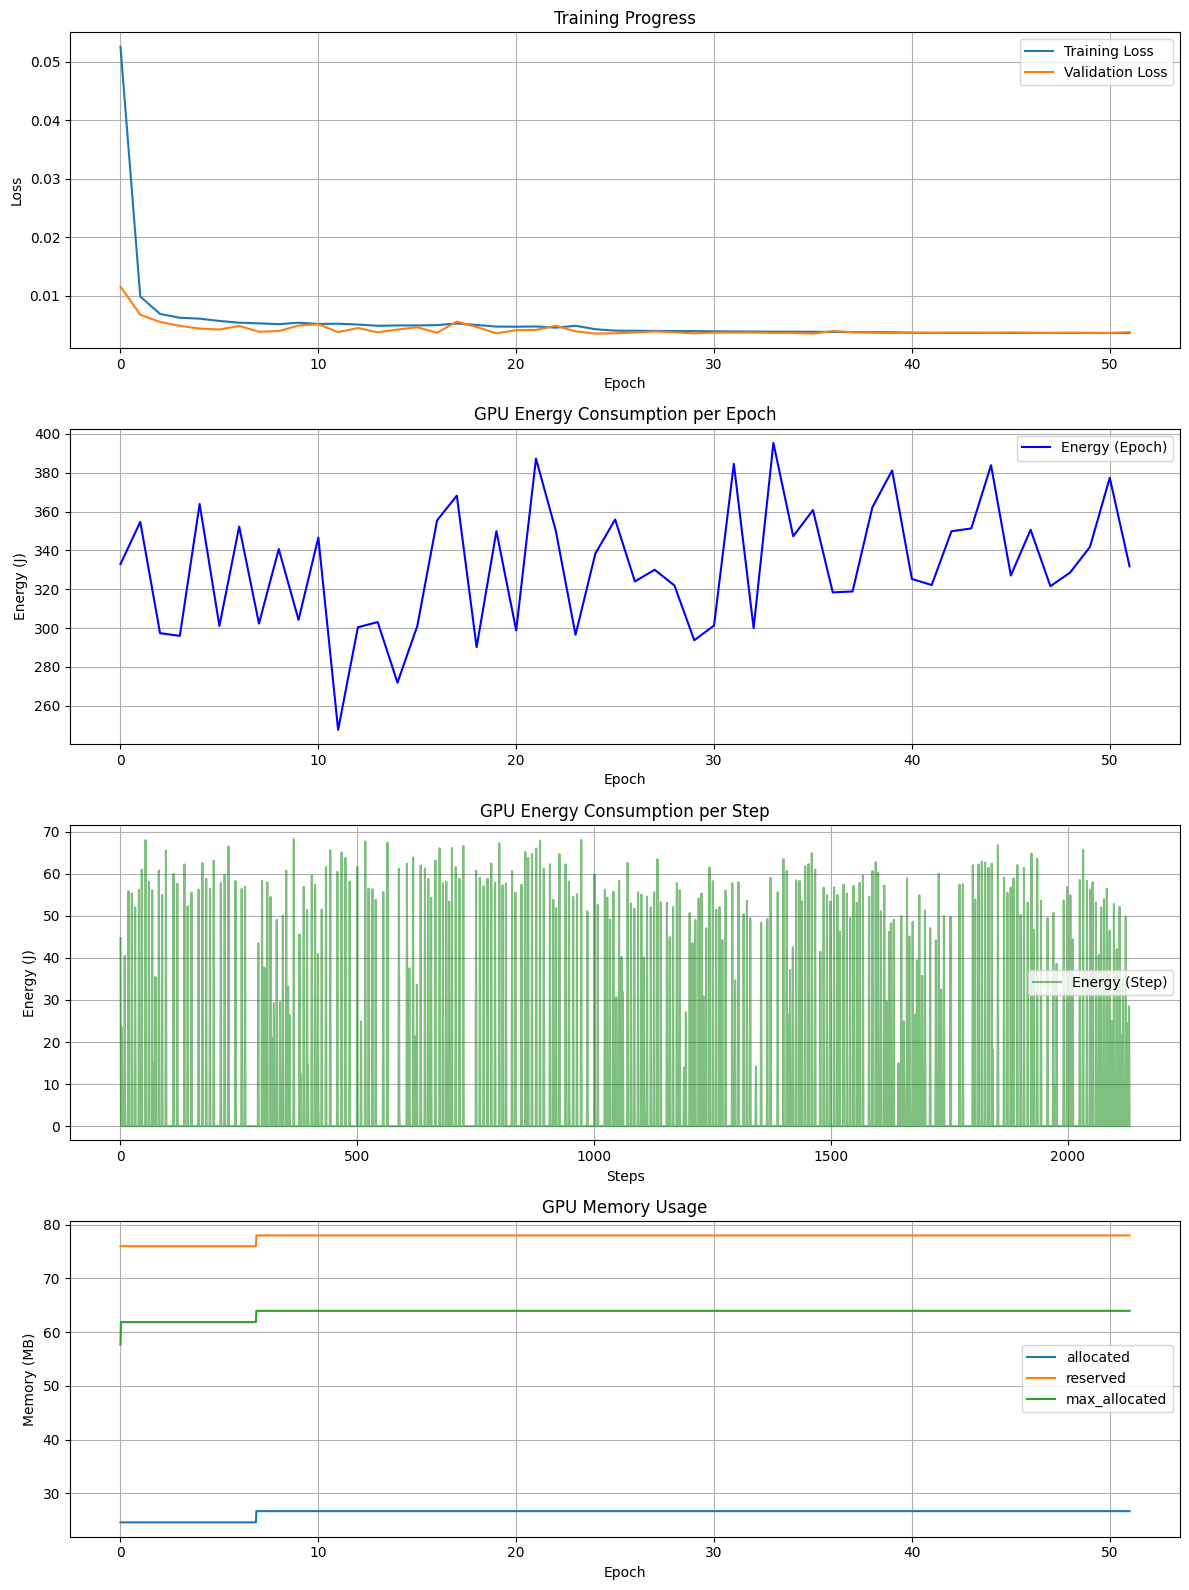

In [10]:
tracker.plot_metrics()

In [11]:
print("Total energy", tracker.total_energy)

Total energy 31495.55499999982


In [12]:
tracker.save_metrics()